This notebook is going to be about exploring the facebook prophet package. It will also be about figuring out how to conduct difference in difference methods. I think that I could acctually end up writing some of these methods from scratch, which will hopefully make me understand the concepts better.

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

from statsmodels.tsa.seasonal import seasonal_decompose

import pickle

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
%%bash

ls ../data/pickles

cardiac_mortality_obesity_dm_df_by_state.pkl
codebook_dfs_dict.pkl
interpol_truncated_MI_mortality_per_state_dict.pkl
myocardial_infarction_df_state_mortality_dict.pkl
state_population_by_year_dict.pkl


## Load data

We'll go ahead and load the dictionary containing interpolated and truncated MI mortality data per state.

In [13]:
with open("../data/pickles/interpol_truncated_MI_mortality_per_state_dict.pkl", 'rb') as f:
    MI_mortality_per_state_df = pickle.load(f)

In [5]:
MI_mortality_per_state_df.keys()

dict_keys(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

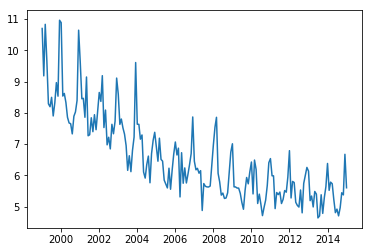

In [12]:
plt.plot(MI_mortality_per_state_df['Missouri']['mortality_per_100k'])

# Prophet

Now, let's try using facebook's Prophet package to model and forecast these different time series, and see how it does.

In [49]:
m = Prophet()

In [50]:
california_target = MI_mortality_per_state_df['California']['mortality_per_100k']

In [56]:
california_df = california_target.reset_index()
california_df.rename(columns={'Month':'ds', 'mortality_per_100k':'y'}, inplace=True)

In [57]:
m.fit(california_df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/joycelee/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [59]:
future = m.make_future_dataframe(periods=24, freq='M')

,ds
212,2016-08-31
213,2016-09-30
214,2016-10-31
215,2016-11-30
216,2016-12-31


In [60]:
forecast=m.predict(future)

In [62]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1999-01-01,4.330134,4.687102,5.145039,4.330134,4.330134,0.596909,0.596909,0.596909,0.596909,0.596909,0.596909,0.0,0.0,0.0,4.927043
1,1999-02-01,4.314840,4.239265,4.704600,4.314840,4.314840,0.151131,0.151131,0.151131,0.151131,0.151131,0.151131,0.0,0.0,0.0,4.465971
2,1999-03-01,4.301025,4.345249,4.820491,4.301025,4.301025,0.284052,0.284052,0.284052,0.284052,0.284052,0.284052,0.0,0.0,0.0,4.585077
3,1999-04-01,4.285731,4.058186,4.528989,4.285731,4.285731,0.008330,0.008330,0.008330,0.008330,0.008330,0.008330,0.0,0.0,0.0,4.294061
4,1999-05-01,4.270930,3.977578,4.431462,4.270930,4.270930,-0.071624,-0.071624,-0.071624,-0.071624,-0.071624,-0.071624,0.0,0.0,0.0,4.199307


In [66]:
california_df.head()

,ds,y
0,1999-01-01,4.907579
1,1999-02-01,4.744970
2,1999-03-01,4.856788
3,1999-04-01,4.506983
4,1999-05-01,4.023989


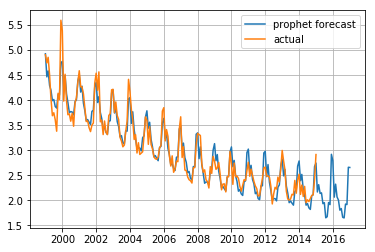

In [68]:
plt.plot(forecast.ds, forecast.yhat, label="prophet forecast")
plt.plot(california_df.ds, california_df.y, label="actual")
plt.grid()
plt.legend()
plt.show()

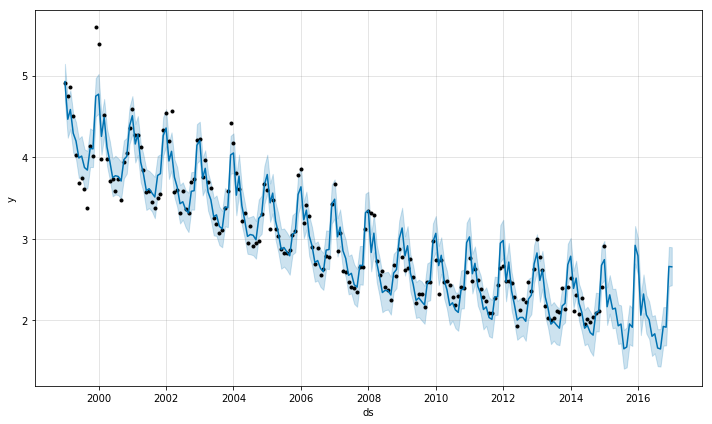

In [69]:
fig1 = m.plot(forecast)

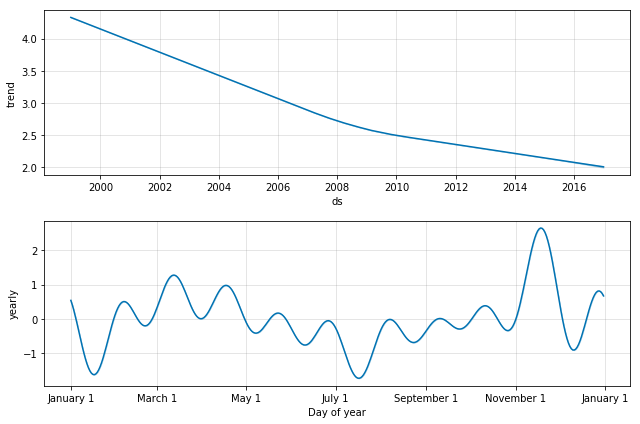

In [70]:
fig2 = m.plot_components(forecast)

In [75]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1999-01-01,4.330134,4.687102,5.145039,4.330134,4.330134,0.596909,0.596909,0.596909,0.596909,0.596909,0.596909,0.0,0.0,0.0,4.927043
1,1999-02-01,4.314840,4.239265,4.704600,4.314840,4.314840,0.151131,0.151131,0.151131,0.151131,0.151131,0.151131,0.0,0.0,0.0,4.465971
2,1999-03-01,4.301025,4.345249,4.820491,4.301025,4.301025,0.284052,0.284052,0.284052,0.284052,0.284052,0.284052,0.0,0.0,0.0,4.585077
3,1999-04-01,4.285731,4.058186,4.528989,4.285731,4.285731,0.008330,0.008330,0.008330,0.008330,0.008330,0.008330,0.0,0.0,0.0,4.294061
4,1999-05-01,4.270930,3.977578,4.431462,4.270930,4.270930,-0.071624,-0.071624,-0.071624,-0.071624,-0.071624,-0.071624,0.0,0.0,0.0,4.199307


We can try a few things here. We can try doing rolling time series cross-validation (more like a learning curve), and see how the prophet object predicts at each fold.

We can also see how well a 'prophet' model that was fitted on one state's time series actually does on predicting another state's data; probably not very well.

Finally, we should experiment with adding regressors to the dataframe and seeing how well it predicts there.

In [73]:
tscv = TimeSeriesSplit(n_splits=10)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 17.0.


Predicted vs actual for test fold 1:


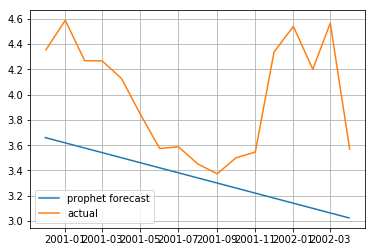

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted vs actual for test fold 2:


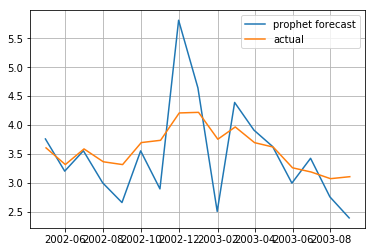

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted vs actual for test fold 3:


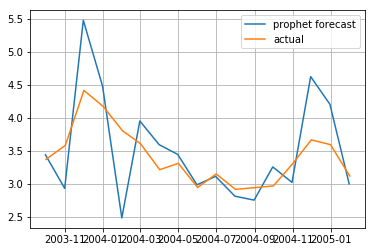

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted vs actual for test fold 4:


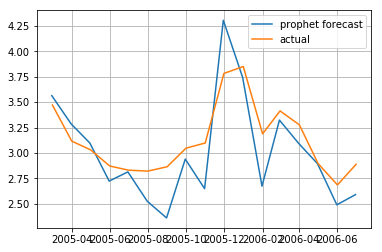

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted vs actual for test fold 5:


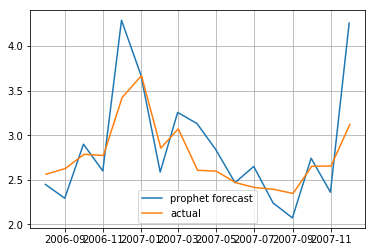

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted vs actual for test fold 6:


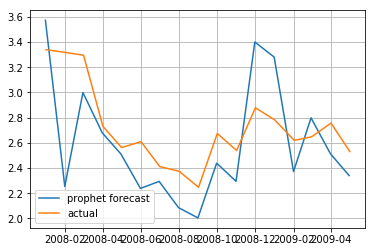

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted vs actual for test fold 7:


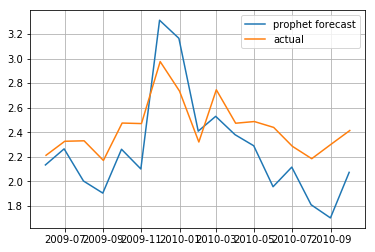

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted vs actual for test fold 8:


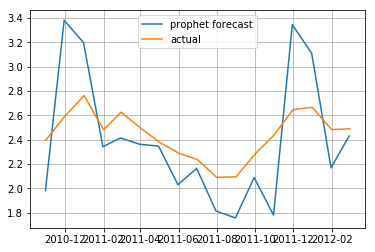

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted vs actual for test fold 9:


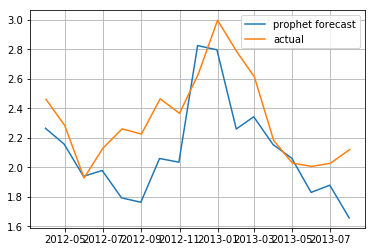

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted vs actual for test fold 10:


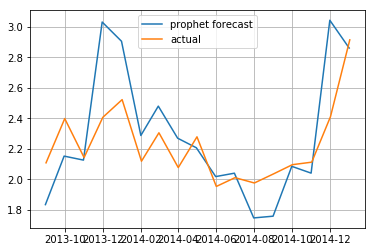

In [83]:
test_rmse_scores = []
i = 1
for train_index, test_index in tscv.split(california_df):
    m = Prophet()
    m.fit(california_df.iloc[train_index])
    future = m.make_future_dataframe(periods=len(test_index), freq='M')
    forecast=m.predict(future)
    
    rmse = np.sqrt(mean_squared_error(california_df.iloc[test_index].y, forecast.iloc[test_index].yhat))
    test_rmse_scores.append(rmse)
    
    print(f"Predicted vs actual for test fold {i}:")
    i += 1
    plt.plot(forecast.iloc[test_index].ds, forecast.iloc[test_index].yhat, label="prophet forecast")
    plt.plot(california_df.iloc[test_index].ds, california_df.iloc[test_index].y, label="actual")
    plt.grid()
    plt.legend()
    plt.show()

In [84]:
print(test_rmse_scores)

[0.7760647574249628, 0.6235076990899212, 0.5533936780177946, 0.2805960447964092, 0.413565142357518, 0.3746011888932821, 0.3121434808490299, 0.3907425171230952, 0.2948549894400431, 0.2782461472759743]


So actually, prophet includes functions to do cross-validation, so we can see whether the results we get from prophet's cross validation are the same as what I got calculating it manually.

In [86]:
m_full_california = Prophet()
m_full_california.fit(california_df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [87]:
df_cv = cross_validation(m_full_california, period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 25 forecasts with cutoffs between 2002-03-05 00:00:00 and 2014-01-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2002-04-01,3.909991,3.706279,4.107886,3.569062,2002-03-05
1,2002-05-01,3.548103,3.372559,3.735658,3.602965,2002-03-05
2,2002-06-01,3.302163,3.125803,3.485406,3.314233,2002-03-05
3,2002-07-01,3.335397,3.137505,3.530642,3.585027,2002-03-05
4,2002-08-01,3.224244,3.039337,3.431275,3.362372,2002-03-05


In [93]:
df_cv.shape

(300, 6)

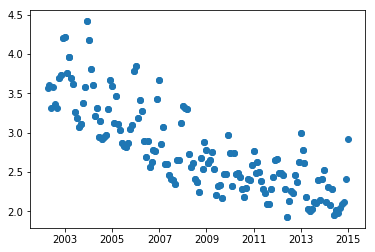

In [103]:
plt.scatter(x=list(df_cv.ds), y=df_cv.y)
#plt.plot(df_cv.ds, df_cv.yhat)
plt.show()

In [ ]:
from fbprophet.diagnostics import performance_metrics

In [106]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
181,37 days,0.044395,0.210701,0.185222,0.069458,0.633333
193,38 days,0.043682,0.209002,0.181473,0.067805,0.633333
49,38 days,0.043583,0.208766,0.181248,0.068171,0.633333
61,41 days,0.044463,0.210863,0.183055,0.068885,0.633333
205,42 days,0.048407,0.220016,0.189601,0.072087,0.600000


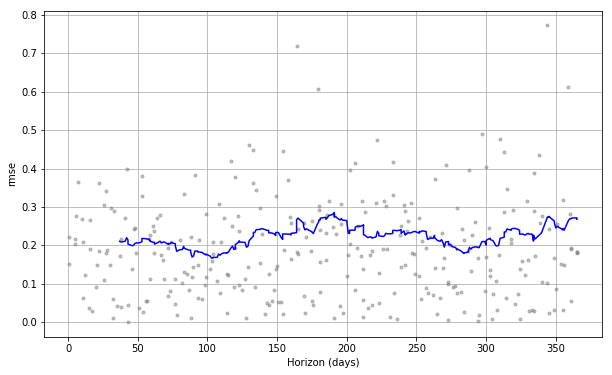

In [107]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

# Difference in differences

Let's work through some toy examples to write some methods for 'discovering' differences in differences.

In [43]:
n = 10
x = list(range(n))

In [121]:
target_A = 2*np.array(x) + 1
target_B = 2*np.array(x) + 3

In [136]:
t = np.array(range(5))

In [138]:
4*t + 1

array([ 1,  5,  9, 13, 17])

In [183]:
def change_slope_at_changepoint(target, new_slope, changepoint=0.5):
    new_target = np.array(target)
    
    changepoint = math.floor(changepoint*len(target))
    
    old_part = list(target[0:changepoint])
    
    y_prior_to_changepoint = target[changepoint-1]
    
    rest_of_timepoints = np.array(range(1, len(target)-changepoint+1))
    changed_target = y_prior_to_changepoint + new_slope*rest_of_timepoints
    
    new_target = old_part + list(changed_target)
    
    return new_target

In [181]:
target_B

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21])

In [201]:
target_C = change_slope_at_changepoint(target_B, 0.5, changepoint=0.5)
target_D = change_slope_at_changepoint(target_A, 1, changepoint=0.4)

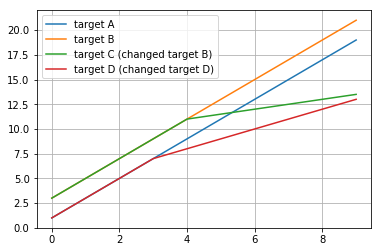

In [202]:
plt.plot(x, target_A, label="target A")
plt.plot(x, target_B, label='target B')
plt.plot(x, target_C, label='target C (changed target B)')
plt.plot(x, target_D, label='target D (changed target D)')
plt.grid()
plt.legend()
plt.show()

In [203]:
data = pd.DataFrame({'target C': target_C, 'target D': target_D})

In [204]:
plt.plot

,target C,target D
0,3.0,1
1,5.0,3
2,7.0,5
3,9.0,7
4,11.0,8
5,11.5,9
6,12.0,10
7,12.5,11
8,13.0,12
9,13.5,13


In [210]:
algo = rpt.Pelt().fit(np.array(target_C))

result = algo.predict(pen=10)

In [211]:
result

[5, 10]

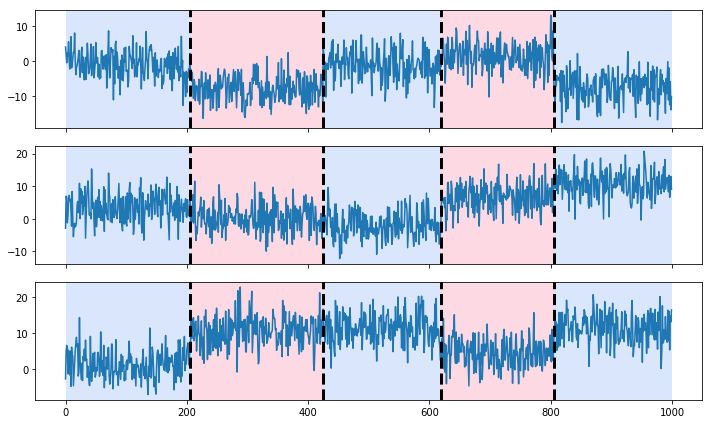

In [205]:
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

In [206]:
result

[205, 425, 620, 805, 1000]

Okay, so all you're going to do for the next half hour is try to figure out how to apply differences in differences to your data set.

We'll use medicaid expansion as the variable that determines 'treatment'; source for this data is [here](https://nashp.org/states-stand-medicaid-expansion-decisions/).

In [ ]:
medicaid_expansion = {}

In [218]:
medicaid_expansion['Alaska'] = 'September 1 2015'
medicaid_expansion['Arizona'] = 'August 1 2013'
medicaid_expansion['Arkansas'] = 'January 1 2014'
medicaid_expansion['California'] = 'November 1 2010'
medicaid_expansion['Colorado'] = 'June 1 2013'
medicaid_expansion['Connecticut'] = 'April 1 2010'
medicaid_expansion['Delaware'] = 'January 1 2014'
medicaid_expansion['District of Columbia'] = 'July 1 2010'
medicaid_expansion['Hawaii'] = 'January 1 2014'
medicaid_expansion['Illinois'] = 'August 1 2013'
medicaid_expansion['Indiana'] = 'February 1 2015'
medicaid_expansion['Iowa'] = 'January 1 2014'
medicaid_expansion['Kentucky'] = 'May 1 2013'
medicaid_expansion['Louisiana'] = 'February 1 2016'
medicaid_expansion['Massachusetts'] = 'July 1 2013'
medicaid_expansion['Maryland'] = 'January 1 2014'
medicaid_expansion['Michigan'] = 'April 1 2014'
medicaid_expansion['Minnesota'] = 'March 1 2010'
medicaid_expansion['Montana'] = 'January 1 2016'
medicaid_expansion['Nevada'] = 'January 1 2014'
medicaid_expansion['New Hampshire'] = 'July 1 2014'
medicaid_expansion['New Jersey'] = 'April 1 2011'
medicaid_expansion['New Mexico'] = 'January 1 2014'
medicaid_expansion['New York'] = 'January 1 2014'
medicaid_expansion['North Dakota'] = 'January 1 2014'
medicaid_expansion['Ohio'] = 'January 1 2014'
medicaid_expansion['Oregon'] = 'January 1 2014'
medicaid_expansion['Pennsylvania'] = 'January 1 2015'
medicaid_expansion['Rhode Island'] = 'January 1 2014'
medicaid_expansion['Vermont'] = 'January 1 2014'
medicaid_expansion['West Virginia'] = 'January 1 2014'
medicaid_expansion['Washington'] = 'January 1 2011'

Now, let's convert these dates into datetimes and then use them to broadcast to the MI mortality dataframes.

In [219]:
for state, date in medicaid_expansion.items():
    medicaid_expansion[state] = pd.to_datetime(date)

In [223]:
min(MI_mortality_per_state_df['California'].index)

Timestamp('1999-01-01 00:00:00')

In [242]:
temp = pd.Series(np.zeros((MI_mortality_per_state_df['California'].shape[0])), index=MI_mortality_per_state_df['California'].index, name='medicaid_expansion')

In [244]:
medicaid_expansion['California']

Timestamp('2010-11-01 00:00:00')

In [251]:
temp2 = pd.Series([1 if date >= medicaid_expansion['California'] else 0 for date, val in temp.iteritems()], index = temp.index) 

In [253]:
def dummy_for_medicaid_expansion(state, df, medicaid_expansion):
    temp = pd.Series(np.zeros(df.shape[0]), index = df.index)
    if state in medicaid_expansion:
        temp = pd.Series([1 if date >= medicaid_expansion[state] else 0 for date, val in temp.iteritems()], index = df.index)
        
    df['medicaid_expansion'] = temp
    return df

In [255]:
for state, df in MI_mortality_per_state_df.items():
    new_df = dummy_for_medicaid_expansion(state, df, medicaid_expansion)
    MI_mortality_per_state_df[state] = new_df

In [259]:
MI_mortality_per_state_df['Washington'].tail()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k,medicaid_expansion
Month,,,,,,
2014-09-01,138.0,52.666667,7.866667,7.134077e+06,1.934378,1
2014-10-01,173.0,52.100000,7.825000,7.143146e+06,2.421902,1
2014-11-01,173.0,51.533333,7.783333,7.152214e+06,2.418831,1
2014-12-01,186.0,50.966667,7.741667,7.161283e+06,2.597300,1
2015-01-01,193.0,50.400000,7.700000,7.170351e+06,2.691640,1


In [260]:
with open("../data/pickles/MI_mortality_medicaid_expansion.pkl", "wb") as f:
    pickle.dump(MI_mortality_per_state_df, f)

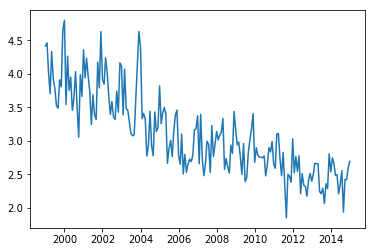

In [262]:
plt.plot(MI_mortality_per_state_df['Washington']['mortality_per_100k'])

In [270]:
res = seasonal_decompose(MI_mortality_per_state_df['Washington']['mortality_per_100k'])

In [287]:
washington = MI_mortality_per_state_df['Washington']

In [288]:
washington.head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k,medicaid_expansion
Month,,,,,,
1999-01-01,258.0,43.700000,5.200,5.842564e+06,4.415869,0
1999-02-01,261.0,43.541667,5.225,5.846860e+06,4.463934,0
1999-03-01,236.0,43.383333,5.250,5.851157e+06,4.033390,0
1999-04-01,217.0,43.225000,5.275,5.855453e+06,3.705947,0
1999-05-01,254.0,43.066667,5.300,5.859750e+06,4.334656,0


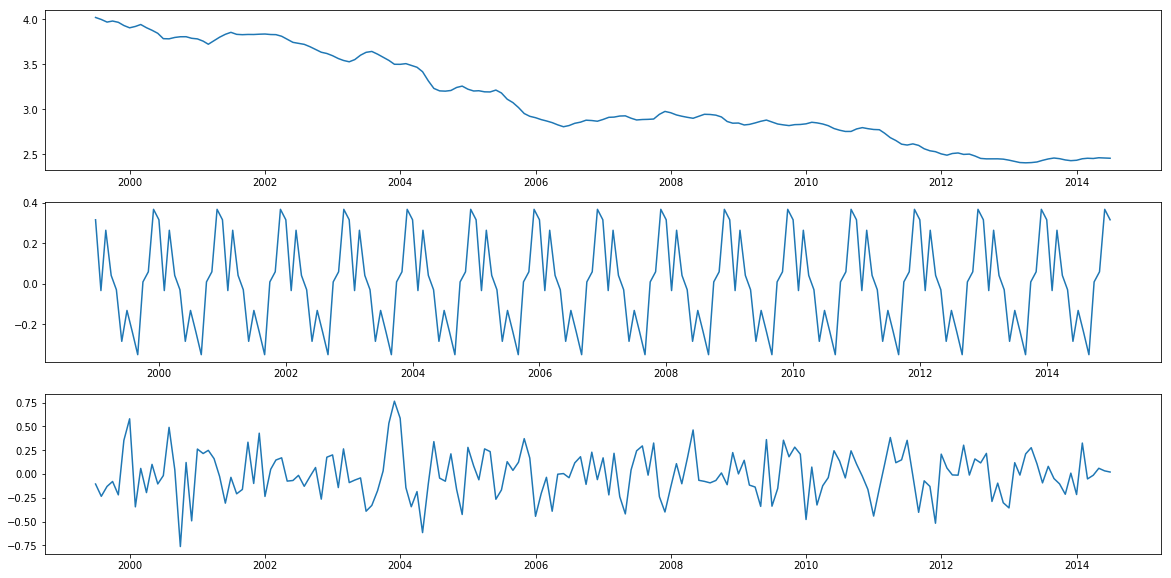

In [286]:
plt.figure(figsize=(20,10))

plt.subplot(3, 1, 1)
plt.plot(res.trend)

plt.subplot(3, 1, 2)
plt.plot(res.seasonal)

plt.subplot(3, 1, 3)
plt.plot(res.resid)

plt.show()

In [323]:
algo = rpt.Pelt().fit(np.array(res.seasonal))

result = algo.predict(pen=10**30)

In [324]:
result

[193]

In [313]:
from numpy.random import normal

In [316]:
t = normal(0, scale=1, size=1000)

In [317]:
algo = rpt.Pelt().fit(t)

result = algo.predict(pen=10)

In [318]:
result

[1000]

In [334]:
with open("../data/pickles/MI_mortality_medicaid_expansion.pkl", "rb") as f:
    dict_of_medicaid_df = pickle.load(f)

In [332]:
dict_of_medicaid_df['California'].head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k,medicaid_expansion
Month,,,,,,
1999-01-01,1644.0,41.500000,6.50,33499204.0,4.907579,0
1999-02-01,1591.0,41.308333,6.55,33530241.0,4.744970,0
1999-03-01,1630.0,41.116667,6.60,33561278.0,4.856788,0
1999-04-01,1514.0,40.925000,6.65,33592315.0,4.506983,0
1999-05-01,1353.0,40.733333,6.70,33623352.0,4.023989,0


In [341]:
new_dict_of_medicaid_df = {}
for key, df in dict_of_medicaid_df.items():
    temp_df = df.copy()
    temp_df['state'] = key
    new_dict_of_medicaid_df[key] = temp_df

In [344]:
all_states_medicaid_df = pd.concat(new_dict_of_medicaid_df.values())

In [346]:
before_2010_df = all_states_medicaid_df[:'2010']

In [347]:
before_2010_df.columns

Index(['Deaths', 'obesity_prevalence', 'diabetes_prevalence', 'Population',
       'mortality_per_100k', 'medicaid_expansion', 'state'],
      dtype='object')

In [356]:
before_2010_df.head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k,medicaid_expansion,state
Month,,,,,,,
1999-01-01,332.0,61.400000,7.400000,4430141.00,7.494118,0.0,Alabama
1999-02-01,332.0,60.833333,7.383333,4431554.25,7.491728,0.0,Alabama
1999-03-01,377.0,60.266667,7.366667,4432967.50,8.504461,0.0,Alabama
1999-04-01,301.0,59.700000,7.350000,4434380.75,6.787870,0.0,Alabama
1999-05-01,314.0,59.133333,7.333333,4435794.00,7.078778,0.0,Alabama


national_model would be trained on all of the state dataframes concatenated together w/ state dropped as a variable; can manually add in lags or moving average etc.

In [348]:
from sklearn.linear_model import LinearRegression

In [351]:
from statsmodels.formula.api import ols

In [355]:
model = ols('mortality_per_100k ~ obesity_prevalence + diabetes_prevalence + state', data=before_2010_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     mortality_per_100k   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     380.8
Date:                Tue, 11 Sep 2018   Prob (F-statistic):               0.00
Time:                        16:07:17   Log-Likelihood:                -7957.3
No. Observations:                7200   AIC:                         1.612e+04
Df Residuals:                    7099   BIC:                         1.681e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            14.0278      0.485     28.919      0.000      13.077      14.979
state[T.Arizona]                                     -4.3077      0.635     -6.787      0.000      -5.552      -3.064
state[T.Arkansas]                                     1.8367      0.645      2.849      0.004       0.573       3.100
state[T.California]                                  -4.1164      0.817     -5.039      0.000      -5.718      -2.515
state[T.Colorado]                                    -6.6169      0.766     -8.643      0.000      -8.118      -5.116
state[T.Connecticut]                                 -4.8441      0.729     -6.648      0.000      -6.272      -3.416
state[T.Delaware]                                     0.7661      0.847      0.905      0.366      -0.894       2.426
state[T.District of Columbia]                        -8.3626      1.118     -7.483      0.000     -10.553      -6.172
state[T.Florida]                                      1.1548      0.711      1.624      0.104      -0.239       2.548
state[T.Georgia]                                     -4.8150      0.618     -7.790      0.000      -6.027      -3.603
state[T.Hawaii]                                      -7.8343      0.668    -11.724      0.000      -9.144      -6.524
state[T.Idaho]                                       -4.1666      0.616     -6.761      0.000      -5.375      -2.959
state[T.Illinois]                                     0.0276      0.694      0.040      0.968      -1.333       1.388
state[T.Indiana]                                     -1.3972      0.675     -2.071      0.038      -2.720      -0.075
state[T.Iowa]                                         4.2222      0.860      4.909      0.000       2.536       5.908
state[T.Kansas]                                      -2.3333      0.648     -3.602      0.000      -3.603      -1.064
state[T.Kentucky]                                    -0.2566      0.601     -0.427      0.670      -1.435       0.922
state[T.Louisiana]                                   -2.2019      0.623     -3.533      0.000      -3.424      -0.980
state[T.Maine]                                       -1.1990      0.813     -1.474      0.141      -2.794       0.396
state[T.Maryland]                                    -1.9764      0.762     -2.593      0.010      -3.471      -0.482
state[T.Massachusetts]                               -2.0530      0.719     -2.855      0.004      -3.463      -0.643
state[T.Michigan]                                    -1.7375      0.734     -2.367      0.018      -3.177      -0.298
state[T.Minnesota]                                   -4.6790      0.722     -6.479      0.000      -6.095      -3.263
state[T.Mississ

In [ ]:
# after 2010:
model_after_2010 = ols('mortality_per_100k ~ obesity_prevalence + diabetes_prevalence + national_model_column + medicaid_expansion', data = after_2010_df).fit()
model_after_2010 = ols('mortality_per_100k ~ obesity_prevalence + diabetes_prevalence + national_model_column + medicaid_expansion + state*medicaid_expansion', data = full_df).fit()
#this has to include the national predication

In [349]:
linear_regr = LinearRegression()

In [ ]:
linear_regr.fit(before_2010_df['obesity_prevalence', 'diabetes_prevalence', 'state'], )